# 1. Install Dependencies and Setup

In [47]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\arthu\AppData\Local\Temp\pip-install-mit6v816\tensorflow-gpu_61fc1466b7804d3f96c5a36f34a0dd73\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not

In [48]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
async-generator               1.10
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bin

In [49]:
import tensorflow as tf
import os

In [50]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [51]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [52]:
import cv2
import imghdr

In [53]:
data_dir = 'data' 

In [54]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [55]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [56]:
import numpy as np
from matplotlib import pyplot as plt

In [57]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 396 files belonging to 2 classes.


In [58]:
data_iterator = data.as_numpy_iterator()

In [59]:
batch = data_iterator.next()

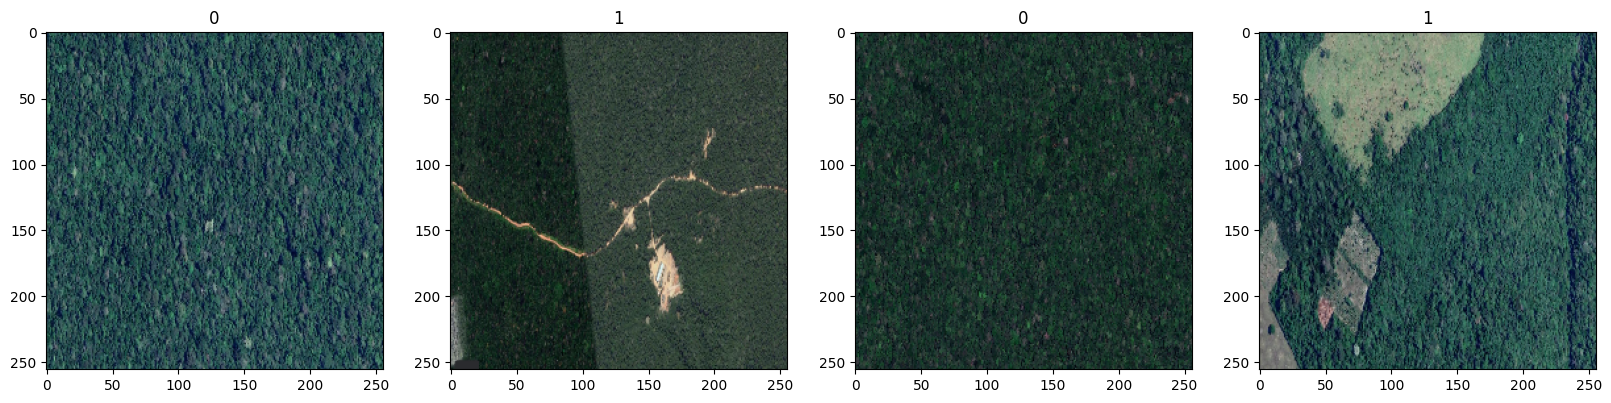

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [61]:
data = data.map(lambda x,y: (x/255, y))

In [62]:
data.as_numpy_iterator().next()

(array([[[[0.12721232, 0.2406921 , 0.1675769 ],
          [0.06337256, 0.15866423, 0.08505424],
          [0.11289217, 0.21085173, 0.13691637],
          ...,
          [0.09970129, 0.20327511, 0.15795037],
          [0.0910677 , 0.19573039, 0.1387163 ],
          [0.1153459 , 0.1836823 , 0.14446661]],
 
         [[0.11409866, 0.21359897, 0.17218505],
          [0.09443934, 0.1999813 , 0.1338027 ],
          [0.11219825, 0.21398899, 0.14921571],
          ...,
          [0.08062959, 0.19875154, 0.13066635],
          [0.08770252, 0.19293936, 0.13522643],
          [0.02097364, 0.06934588, 0.03353094]],
 
         [[0.10833333, 0.19730085, 0.15871936],
          [0.08504136, 0.19484529, 0.13919117],
          [0.07417281, 0.18397672, 0.12802544],
          ...,
          [0.10079652, 0.20863202, 0.13517153],
          [0.09267461, 0.19055144, 0.13264245],
          [0.10679534, 0.18387407, 0.1490288 ]],
 
         ...,
 
         [[0.14974879, 0.18898286, 0.16872856],
          [0.06350

# 5. Split Data

In [63]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [64]:
train_size

9

In [65]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [66]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [68]:
model = Sequential()

In [69]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [70]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [72]:
logdir='logs'

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 24s 2s/step - loss: 0.7242 - accuracy: 0.7569 - val_loss: 0.6021 - val_accuracy: 0.7031
Epoch 2/20
9/9 [==============================] - 21s 2s/step - loss: 0.5380 - accuracy: 0.7396 - val_loss: 0.5804 - val_accuracy: 0.6406
Epoch 3/20
9/9 [==============================] - 21s 2s/step - loss: 0.4850 - accuracy: 0.7292 - val_loss: 0.4050 - val_accuracy: 0.7812
Epoch 4/20
9/9 [==============================] - 21s 2s/step - loss: 0.3437 - accuracy: 0.8542 - val_loss: 0.3745 - val_accuracy: 0.7969
Epoch 5/20
9/9 [==============================] - 21s 2s/step - loss: 0.3207 - accuracy: 0.8785 - val_loss: 0.3426 - val_accuracy: 0.8750
Epoch 6/20
9/9 [==============================] - 21s 2s/step - loss: 0.2276 - accuracy: 0.9097 - val_loss: 0.3724 - val_accuracy: 0.8594
Epoch 7/20
9/9 [==============================] - 21s 2s/step - loss: 0.2313 - accuracy: 0.9132 - val_loss: 0.2229 - val_accuracy: 0.9062
Epoch 8/20
9/9 [==================

# 8. Plot Performance

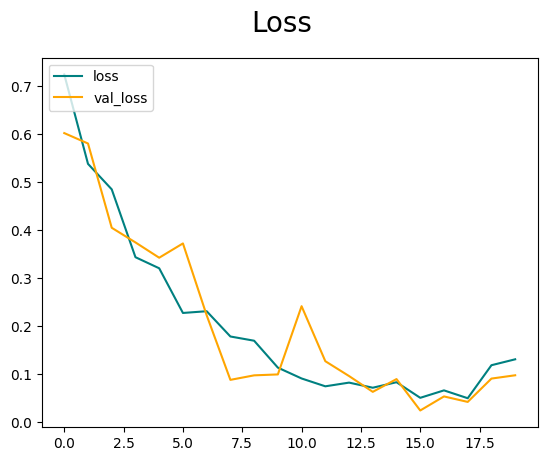

In [75]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

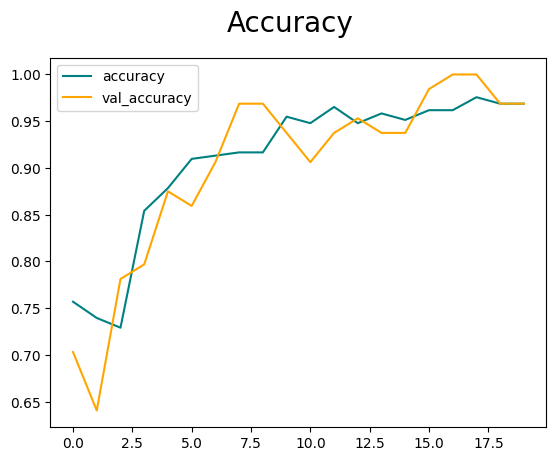

In [76]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [77]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [78]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [79]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 444ms/step


In [80]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8333333, shape=(), dtype=float32) tf.Tensor(0.8333333, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float32)


# 10. Test

In [81]:
import cv2

In [110]:
imgclasses = []
count = 0 
numberofimages = 14 #amount of colected images 

while count < numberofimages: 
    img = cv2.imread('cropped'+str(count)+'.jpg')
    #plt.imshow(img)
    #plt.show()
    resize = tf.image.resize(img, (256,256))
    #plt.imshow(resize.numpy().astype(int))
    #plt.show()
    yhat = model.predict(np.expand_dims(resize/255, 0))
    count +=1
    print(yhat)
    if yhat > 0.8: 
        imgclasses.append(str(count)+' status:1')
    else:
        imgclasses.append(str(count)+' status:0')

1/1 [==============================] - 0s 61ms/step
[[0.54084885]]
1/1 [==============================] - 0s 62ms/step
[[0.4739223]]
1/1 [==============================] - 0s 54ms/step
[[0.88194937]]
1/1 [==============================] - 0s 62ms/step
[[0.4809801]]
1/1 [==============================] - 0s 75ms/step
[[0.5145073]]
1/1 [==============================] - 0s 68ms/step
[[0.49519384]]
1/1 [==============================] - 0s 75ms/step
[[0.5077721]]
1/1 [==============================] - 0s 68ms/step
[[0.45822158]]
1/1 [==============================] - 0s 74ms/step
[[0.53939545]]
1/1 [==============================] - 0s 67ms/step
[[0.5153453]]
1/1 [==============================] - 0s 54ms/step
[[0.47701445]]
1/1 [==============================] - 0s 64ms/step
[[0.9897644]]
1/1 [==============================] - 0s 75ms/step
[[0.9775751]]
1/1 [==============================] - 0s 61ms/step
[[0.47548112]]


In [111]:
imgclasses

['1 status:0',
 '2 status:0',
 '3 status:1',
 '4 status:0',
 '5 status:0',
 '6 status:0',
 '7 status:0',
 '8 status:0',
 '9 status:0',
 '10 status:0',
 '11 status:0',
 '12 status:1',
 '13 status:1',
 '14 status:0']

TypeError: Image data of dtype object cannot be converted to float

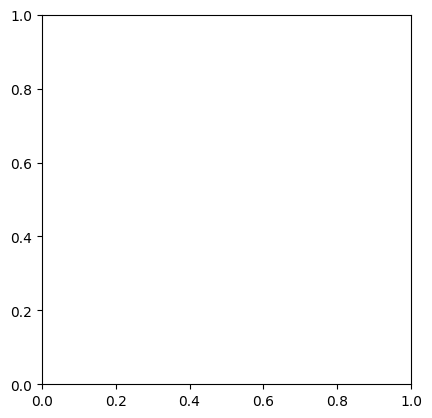

In [106]:
img = cv2.imread('')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# 11. Save the Model

In [100]:
from tensorflow.keras.models import load_model

In [101]:
model.save(os.path.join('models','imageclassifier.h5'))

In [102]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [96]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined